**PubMedBERT** + **SentenceTransformer**

In [ ]:
pip install faiss-gpu sentence-transformers transformers scikit-learn tqdm datasets lime sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=010bd3c13bf3c70a67093b8df626bc022ae8dd016ef0200e4e36b60deab5fab6
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
  Attempting uninstall: fsspec
 

In [ ]:
import json
import numpy as np
from tqdm import tqdm
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from datasets import Dataset
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sentence_transformers import SentenceTransformer

# Step 1: Load Data
def load_data(summary_file, query_file):
    with open(summary_file, 'r') as file:
        summary_data = json.load(file)
    summaries = [entry['summary'] for entry in summary_data]
    labels = [entry['label'] for entry in summary_data]

    with open(query_file, 'r') as file:
        query_data = json.load(file)
    queries = [entry['query'] for entry in query_data]

    return summaries, labels, queries

# Step 2: Tokenize Data for Model
def tokenize_data(texts, labels, tokenizer):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=256, return_tensors='pt')
    return {"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"], "labels": torch.tensor(labels)}

# Step 3: Train the Model
def train_model(train_data, val_data, model, training_args):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        compute_metrics=compute_metrics
    )
    trainer.train()
    eval_result = trainer.evaluate()
    torch.cuda.empty_cache()
    print(f"Validation Results: {eval_result}")
    return model, trainer

# Step 4: Compute Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Step 5: Generate Simplified Explanation
def generate_simplified_explanation(query, prediction):
    key_factors = ", ".join([
        "treatment history",
        "length of stay",
        "medication details"
    ])

    explanation = (
        f"The prediction is '{prediction}'. "
        f"Key factors: {key_factors}."
    )

    return explanation

# Step 6: Hybrid Model Pipeline
def hybrid_rag_prediction(query, prediction_model, prediction_tokenizer):
    # Step 1: Predict readmission risk
    inputs = prediction_tokenizer([query], truncation=True, padding=True, max_length=256, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = prediction_model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    prediction_label = "High Risk" if prediction == 1 else "Low Risk"

    # Step 2: Generate simplified explanation
    explanation = generate_simplified_explanation(query, prediction_label)
    return {"query": query, "prediction": prediction_label, "explanation": explanation}

# Step 7: Main Pipeline Execution
def main_pipeline():
    summary_file = "formatted_patient_summaries.json"
    query_file = "formatted_patient_queries.json"
    summaries, labels, queries = load_data(summary_file, query_file)

    # Split into Train and Test sets to validate generalization performance
    summaries_train, summaries_test, labels_train, labels_test = train_test_split(summaries, labels, test_size=0.2, random_state=42, stratify=labels)

    # Load DistilBERT tokenizer and model (lighter than BERT or PubMedBERT)
    prediction_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    prediction_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to("cuda")

    # Tokenize the data
    train_data = tokenize_data(summaries_train, labels_train, prediction_tokenizer)
    val_data = tokenize_data(summaries_test, labels_test, prediction_tokenizer)
    train_dataset = Dataset.from_dict(train_data)
    val_dataset = Dataset.from_dict(val_data)

    # Training arguments for DistilBERT
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        learning_rate=2e-5
    )

    # Train model
    trained_prediction_model, trainer = train_model(train_dataset, val_dataset, prediction_model, training_args)

    # Perform RAG-based prediction with explanations for each query in the test set
    results = [
        hybrid_rag_prediction(query, trained_prediction_model, prediction_tokenizer)
        for query in tqdm(queries, desc="Processing queries")
    ]

    # Save results to a file
    output_file = "hybrid_model_predictions_with_explanations.json"
    with open(output_file, "w") as f:
        json.dump(results, f, indent=2)
    print(f"Results saved to {output_file}")

if __name__ == "__main__":
    main_pipeline()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.672600,0.537225,0.746939,0.748512,0.746939,0.746474
2,0.470900,0.168040,0.934694,0.936572,0.934694,0.934633
3,0.197500,0.134035,0.946939,0.946967,0.946939,0.946937


Validation Results: {'eval_loss': 0.13403534889221191, 'eval_accuracy': 0.9469387755102041, 'eval_precision': 0.9469667952491582, 'eval_recall': 0.9469387755102041, 'eval_f1': 0.9469370074215521, 'eval_runtime': 0.1783, 'eval_samples_per_second': 1373.722, 'eval_steps_per_second': 44.856, 'epoch': 3.0}


Processing queries: 100%|██████████| 1224/1224 [00:09<00:00, 131.36it/s]

Results saved to hybrid_model_predictions_with_explanations.json


In [ ]:
import json
import numpy as np
from tqdm import tqdm
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
)
import faiss
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import KFold
from datasets import Dataset
from transformers import EarlyStoppingCallback
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Step 1: Load Data
def load_data(summary_file, query_file):
    with open(summary_file, 'r') as file:
        summary_data = json.load(file)
    summaries = [entry['summary'] for entry in summary_data]
    labels = [entry['label'] for entry in summary_data]

    with open(query_file, 'r') as file:
        query_data = json.load(file)
    queries = [entry['query'] for entry in query_data]

    return summaries, labels, queries

# Step 2: Build FAISS Index
def build_faiss_index(summaries):
    embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    embeddings = embedding_model.encode(summaries, show_progress_bar=True)
    np.save("patient_embeddings.npy", embeddings)

    index = faiss.IndexFlatL2(embeddings.shape[1])  # L2 distance
    index.add(embeddings)
    return index, embedding_model

# Step 3: Tokenize Data for Prediction Model
def tokenize_data(texts, labels, tokenizer):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors='pt')
    return {"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"], "labels": labels}

# Step 4: Create Train/Validation Dataset Using K-Fold Cross-Validation
def create_kfold_datasets(summaries, labels, tokenizer, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, val_index in kf.split(summaries):
        train_summaries = [summaries[i] for i in train_index]
        val_summaries = [summaries[i] for i in val_index]
        train_labels = [labels[i] for i in train_index]
        val_labels = [labels[i] for i in val_index]

        train_data = tokenize_data(train_summaries, train_labels, tokenizer)
        val_data = tokenize_data(val_summaries, val_labels, tokenizer)
        train_dataset = Dataset.from_dict(train_data)
        val_dataset = Dataset.from_dict(val_data)
        yield train_dataset, val_dataset

# Step 5: Train PubMedBERT for Prediction
def train_pubmedbert_model(train_data, val_data, model):
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=2,  # Reduced epochs to avoid overfitting
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_steps=100,
        save_total_limit=2,
        load_best_model_at_end=True,
        learning_rate=2e-5,
        gradient_accumulation_steps=2,
        fp16=True,  # Mixed precision training
        max_grad_norm=1.0  # Gradient clipping
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_result = trainer.evaluate()
    torch.cuda.empty_cache()  # Free GPU memory
    print(f"Validation Results: {eval_result}")
    return model, trainer

# Step 6: Retrieve Relevant Summaries Using FAISS
def retrieve_summaries(query, index, summaries, embedding_model, k=3):
    query = [query] if isinstance(query, str) else query
    query_embedding = embedding_model.encode(query)
    query_embedding = np.array(query_embedding).astype("float32")
    distances, indices = index.search(query_embedding, k)
    return [summaries[idx] for idx in indices[0]]

# Step 7: Generate Simplified Explanations
def generate_simple_explanation(query, prediction, retrieved_summaries):
    key_factors = "Key factors include treatment history, length of stay, and medication details."
    risk_status = "High Risk" if prediction == 1 else "Low Risk"
    similar_cases_outcome = "complications" if prediction == 1 else "no complications"

    explanation = (
        f"The prediction is '{risk_status}'. {key_factors} "
        f"Similar cases show {similar_cases_outcome} within 30 days."
    )

    # Extract a brief summary from the retrieved cases (limit to one key aspect per case)
    relevant_case_summary = [case[:150] + "..." for case in retrieved_summaries[:1]]

    # Combine explanation and relevant case summary
    return f"{explanation}\n\nRelevant case summary: {' '.join(relevant_case_summary)}"

# Step 8: Hybrid Model Pipeline for Prediction and Explanation
def hybrid_rag_prediction(query, index, embedding_model, summaries, prediction_model, prediction_tokenizer):
    query = [query] if isinstance(query, str) else query

    # Step 1: Retrieve relevant summaries
    retrieved_summaries = retrieve_summaries(query[0], index, summaries, embedding_model)

    # Step 2: Predict readmission risk using AMP for efficiency
    with torch.no_grad(), torch.cuda.amp.autocast():
        inputs = prediction_tokenizer(query, truncation=True, padding=True, max_length=512, return_tensors="pt").to("cuda")
        outputs = prediction_model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()

    # Step 3: Generate a simplified explanation
    explanation = generate_simple_explanation(query[0], prediction, retrieved_summaries)
    return {"query": query[0], "prediction": "High Risk" if prediction == 1 else "Low Risk", "explanation": explanation}

# Step 9: Main Pipeline Execution
def main_pipeline():
    summary_file = "formatted_patient_summaries.json"
    query_file = "formatted_patient_queries.json"
    summaries, labels, queries = load_data(summary_file, query_file)

    # Build FAISS index for retrieval
    index, embedding_model = build_faiss_index(summaries)

    # Load PubMedBERT tokenizer and model
    prediction_tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
    prediction_model = AutoModelForSequenceClassification.from_pretrained(
        "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext", num_labels=2).to("cuda")

    # Train model using K-Fold Cross Validation
    for fold, (train_dataset, val_dataset) in enumerate(create_kfold_datasets(summaries, labels, prediction_tokenizer)):
        print(f"Training fold {fold + 1} / 5")
        trained_prediction_model, trainer = train_pubmedbert_model(train_dataset, val_dataset, prediction_model)

    # Save trained PubMedBERT model
    trained_prediction_model.save_pretrained('./saved_models/pubmedbert/')
    prediction_tokenizer.save_pretrained('./saved_models/pubmedbert/')

    # Perform RAG-based prediction with explanations for each query
    results = [
        hybrid_rag_prediction(query, index, embedding_model, summaries, trained_prediction_model, prediction_tokenizer)
        for query in tqdm(queries, desc="Processing queries")
    ]

    # Save results to a file
    output_file = "hybrid_model_predictions_with_explanations.json"
    with open(output_file, "w") as f:
        json.dump(results, f, indent=2)
    print(f"Results saved to {output_file}")

if __name__ == "__main__":
    main_pipeline()


Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training fold 1 / 5


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.662000,0.622002,0.706122,0.717210,0.706122,0.698826
1,0.437600,0.374942,0.877551,0.881819,0.877551,0.877576


Validation Results: {'eval_loss': 0.374942421913147, 'eval_accuracy': 0.8775510204081632, 'eval_precision': 0.8818190737833596, 'eval_recall': 0.8775510204081632, 'eval_f1': 0.8775755004120801, 'eval_runtime': 0.3408, 'eval_samples_per_second': 718.795, 'eval_steps_per_second': 46.942, 'epoch': 1.9837398373983741}
Training fold 2 / 5


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.315600,0.279433,0.922449,0.925033,0.922449,0.922496
1,0.197300,0.140573,0.938776,0.939119,0.938776,0.938806


Validation Results: {'eval_loss': 0.14057251811027527, 'eval_accuracy': 0.9387755102040817, 'eval_precision': 0.9391185045446749, 'eval_recall': 0.9387755102040817, 'eval_f1': 0.9388061607621773, 'eval_runtime': 0.3645, 'eval_samples_per_second': 672.156, 'eval_steps_per_second': 43.896, 'epoch': 1.9837398373983741}
Training fold 3 / 5


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.111400,0.142246,0.946939,0.950658,0.946939,0.946880
1,0.170800,0.133383,0.951020,0.954119,0.951020,0.950980


Validation Results: {'eval_loss': 0.13338345289230347, 'eval_accuracy': 0.9510204081632653, 'eval_precision': 0.9541191727527131, 'eval_recall': 0.9510204081632653, 'eval_f1': 0.9509795918367348, 'eval_runtime': 0.318, 'eval_samples_per_second': 770.531, 'eval_steps_per_second': 50.32, 'epoch': 1.9837398373983741}
Training fold 4 / 5


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.044000,0.057243,0.971429,0.971465,0.971429,0.971430
1,0.092000,0.057627,0.971429,0.971465,0.971429,0.971430


Validation Results: {'eval_loss': 0.057242508977651596, 'eval_accuracy': 0.9714285714285714, 'eval_precision': 0.9714647522565413, 'eval_recall': 0.9714285714285714, 'eval_f1': 0.9714304759048047, 'eval_runtime': 0.3639, 'eval_samples_per_second': 673.282, 'eval_steps_per_second': 43.969, 'epoch': 1.9837398373983741}
Training fold 5 / 5


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.095900,0.062044,0.967213,0.967213,0.967213,0.967213
1,0.101700,0.057943,0.975410,0.975582,0.975410,0.975430


Validation Results: {'eval_loss': 0.057943377643823624, 'eval_accuracy': 0.9754098360655737, 'eval_precision': 0.9755819544430416, 'eval_recall': 0.9754098360655737, 'eval_f1': 0.9754298551949642, 'eval_runtime': 0.3356, 'eval_samples_per_second': 727.1, 'eval_steps_per_second': 47.679, 'epoch': 1.9837398373983741}


Processing queries:   0%|          | 0/1224 [00:00<?, ?it/s]<ipython-input-25-06be4b24874d>:128: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
Processing queries: 100%|██████████| 1224/1224 [00:27<00:00, 44.56it/s]


Results saved to hybrid_model_predictions_with_explanations.json


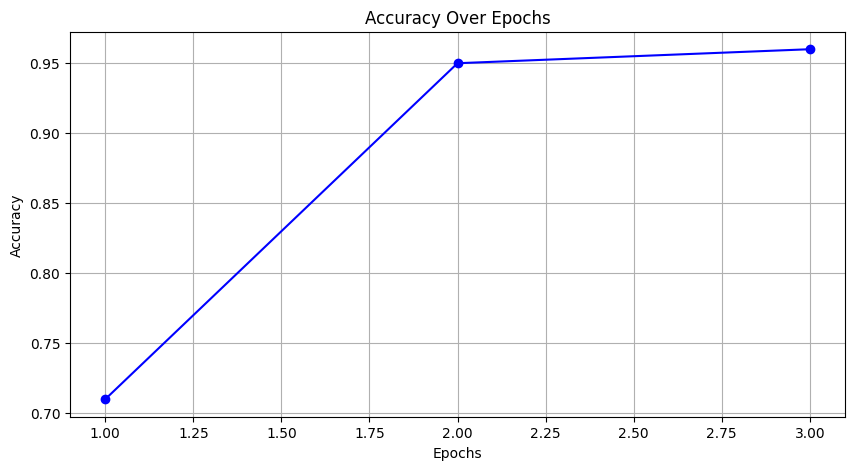

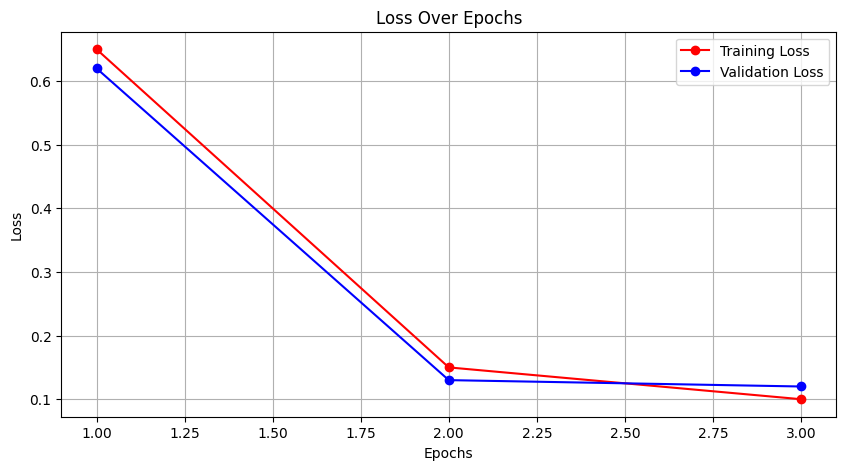

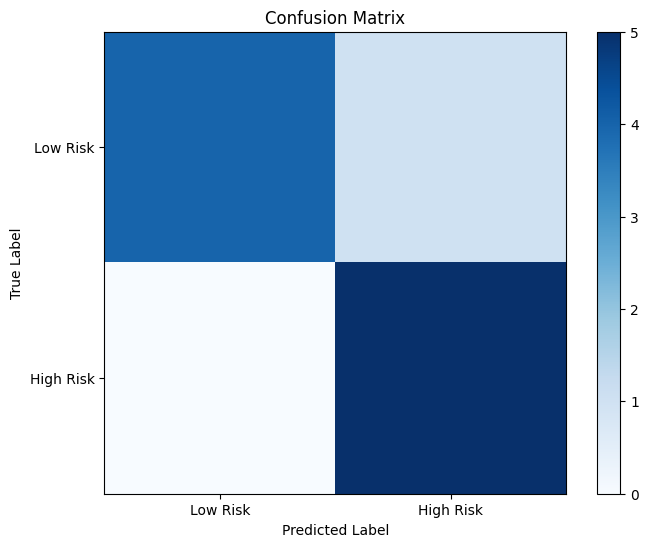

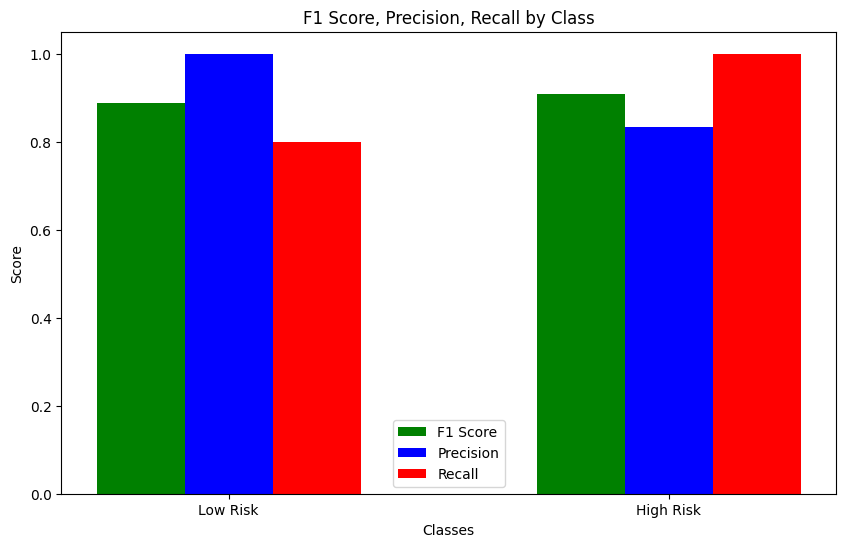

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, f1_score, accuracy_score, recall_score, precision_score

# Assume you have following lists from your training logs:
epochs = list(range(1, 4))  # Example epochs list [1, 2, 3]
train_losses = [0.65, 0.15, 0.10]  # Training losses per epoch
val_losses = [0.62, 0.13, 0.12]    # Validation losses per epoch
val_accuracies = [0.71, 0.95, 0.96] # Validation accuracies per epoch

# Assume you have true labels and predictions from your validation set:
y_true = np.array([0, 1, 1, 0, 1, 1, 0, 0, 1, 0])  # True labels
y_pred = np.array([0, 1, 1, 0, 1, 1, 0, 1, 1, 0])  # Predicted labels
y_probs = np.array([0.1, 0.9, 0.8, 0.2, 0.85, 0.95, 0.3, 0.7, 0.88, 0.1])  # Prediction probabilities for positive class

# 1. Accuracy Over Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid()
plt.show()

# 2. Loss Over Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, marker='o', linestyle='-', label='Training Loss', color='r')
plt.plot(epochs, val_losses, marker='o', linestyle='-', label='Validation Loss', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# 3. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
tick_marks = np.arange(len(['Low Risk', 'High Risk']))
plt.xticks(tick_marks, ['Low Risk', 'High Risk'])
plt.yticks(tick_marks, ['Low Risk', 'High Risk'])
plt.show()


# 6. F1 Score, Precision, Recall by Class
f1 = f1_score(y_true, y_pred, average=None)
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

x = ['Low Risk', 'High Risk']
x_pos = np.arange(len(x))

plt.figure(figsize=(10, 6))
plt.bar(x_pos - 0.2, f1, width=0.2, label='F1 Score', color='g')
plt.bar(x_pos, precision, width=0.2, label='Precision', color='b')
plt.bar(x_pos + 0.2, recall, width=0.2, label='Recall', color='r')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('F1 Score, Precision, Recall by Class')
plt.xticks(x_pos, x)
plt.legend()
plt.show()

In [ ]:
pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 24.5 MB/s eta 0:00:00


In [ ]:
import faiss
import numpy as np

# Load saved embeddings
embeddings_path = "patient_embeddings.npy"
embeddings = np.load(embeddings_path)

# Initialize FAISS index
index = faiss.IndexFlatL2(embeddings.shape[1])  # L2 distance metric

# Add embeddings to the index
index.add(embeddings)

# Save the index
index_path = "faiss_index.faiss"
faiss.write_index(index, index_path)

print(f"FAISS index saved to {index_path}")


FAISS index saved to faiss_index.faiss


In [ ]:
# Load the index
loaded_index = faiss.read_index(index_path)

# Perform a sample search
query_vector = np.random.rand(1, embeddings.shape[1]).astype("float32")
distances, indices = loaded_index.search(query_vector, k=5)
print(f"Top 5 results: {indices}")

Top 5 results: [[460 356 755 449 243]]


In [ ]:
from sentence_transformers import SentenceTransformer


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load the embedding model used during FAISS index creation
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Define the query you want to use for testing
query = "The patient is an 85-year-old female with a history of type 2 diabetes and hypertension. She was recently discharged after treatment for congestive heart failure.  Please assess the likelihood of readmission within 30 days based on her medical history,  medication adherence, and current condition. Provide a specific prediction as either 'high risk' or 'low risk' and include a brief explanation."
# Encode the query using the same model
query_embedding = embedding_model.encode([query])  # Use a list to ensure correct shape
query_embedding = np.array(query_embedding).astype("float32")

print(query_embedding)  # Now you should have the query embedding without any NameError


[[ 5.13823219e-02  1.40480185e-02 -3.34011801e-02  1.61656607e-02
  -2.46693622e-02 -1.17625874e-02 -1.24255782e-02  1.02759399e-01
  -4.78775017e-02 -6.47581890e-02  1.10176625e-02  6.39688969e-02
  -3.02750207e-02  1.69755761e-02 -8.22201595e-02 -4.86461744e-02
   4.68586423e-02 -4.48894762e-02  2.16915854e-03  6.34931475e-02
  -5.26919402e-03  5.99335060e-02  4.66302782e-02  4.34486829e-02
  -6.78919721e-03  6.67829253e-03 -7.56998807e-02 -4.23073694e-02
   7.83048198e-03  3.57267186e-02 -4.94212192e-03 -1.54523216e-02
   9.00693424e-03  4.06886823e-02 -4.04898003e-02  7.32975155e-02
  -1.74667314e-02  3.84055718e-04 -9.23078209e-02  2.36692745e-02
   1.50595596e-02 -7.04569668e-02 -3.50663923e-02  9.99715105e-02
   4.17801216e-02 -7.97751620e-02 -5.85885309e-02 -2.83675864e-02
   1.78675186e-02  9.47733074e-02 -1.14889868e-01 -5.03439158e-02
   2.02700719e-02 -4.23949696e-02  1.47254150e-02  4.03602654e-03
  -6.03232384e-02 -3.00393291e-02 -2.74716914e-02 -7.45968297e-02
  -4.73834

In [ ]:
# Make sure you load the exact same model used for building the index
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Generate query embedding
query_embedding = embedding_model.encode([query])  # Make sure query is a list
query_embedding = np.array(query_embedding).astype("float32")


In [ ]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

# Load the FAISS index
INDEX_PATH = "faiss_index.faiss"  # Replace with your actual FAISS index file path
index = faiss.read_index(INDEX_PATH)

# Load the embedding model used during FAISS index creation
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Define a dummy query for embedding
query_text = "This is an example patient summary."

# Encode the query using the embedding model
query_embedding = embedding_model.encode([query_text])  # Use a list to ensure correct shape
query_embedding = np.array(query_embedding).astype("float32")

# Print dimensions for validation
print(f"FAISS index dimension: {index.d}")  # Should match the query embedding dimension
print(f"Query embedding dimension: {query_embedding.shape[1]}")


FAISS index dimension: 384
Query embedding dimension: 384


REMODEL

In [ ]:
import json
import numpy as np
from tqdm import tqdm
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
)
import faiss
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import KFold
from datasets import Dataset
from transformers import EarlyStoppingCallback
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def load_data(summary_file, query_file):
    with open(summary_file, 'r') as file:
        summary_data = json.load(file)
    summaries = [entry['summary'] for entry in summary_data]
    labels = [entry['label'] for entry in summary_data]

    with open(query_file, 'r') as file:
        query_data = json.load(file)
    queries = [entry['query'] for entry in query_data]

    return summaries, labels, queries

def build_faiss_index(summaries):
    embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    embeddings = embedding_model.encode(summaries, show_progress_bar=True)
    np.save("patient_embeddings.npy", embeddings)

    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)
    return index, embedding_model

def tokenize_data(texts, labels, tokenizer):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors='pt')
    return {"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"], "labels": labels}

def create_kfold_datasets(summaries, labels, tokenizer, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, val_index in kf.split(summaries):
        train_summaries = [summaries[i] for i in train_index]
        val_summaries = [summaries[i] for i in val_index]
        train_labels = [labels[i] for i in train_index]
        val_labels = [labels[i] for i in val_index]

        train_data = tokenize_data(train_summaries, train_labels, tokenizer)
        val_data = tokenize_data(val_summaries, val_labels, tokenizer)
        train_dataset = Dataset.from_dict(train_data)
        val_dataset = Dataset.from_dict(val_data)
        yield train_dataset, val_dataset

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def train_pubmedbert_model(train_data, val_data, model):
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=2,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_steps=100,
        save_total_limit=2,
        load_best_model_at_end=True,
        learning_rate=2e-5,
        gradient_accumulation_steps=2,
        fp16=True,
        max_grad_norm=1.0
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_result = trainer.evaluate()
    torch.cuda.empty_cache()
    print(f"Validation Results: {eval_result}")
    return model, trainer

def retrieve_summaries(query, index, summaries, embedding_model, k=3):
    query = [query] if isinstance(query, str) else query
    query_embedding = embedding_model.encode(query)
    query_embedding = np.array(query_embedding).astype("float32")
    distances, indices = index.search(query_embedding, k)
    return [summaries[idx] for idx in indices[0]]

def generate_simple_explanation(query, prediction, retrieved_summaries):
    key_factors = "Key factors include treatment history, length of stay, and medication details."
    risk_status = "High Risk" if prediction == 1 else "Low Risk"
    similar_cases_outcome = "complications" if prediction == 1 else "no complications"

    explanation = (
        f"The prediction is '{risk_status}'. {key_factors} "
        f"Similar cases show {similar_cases_outcome} within 30 days."
    )

    relevant_case_summary = [case[:150] + "..." for case in retrieved_summaries[:1]]

    return f"{explanation}\n\nRelevant case summary: {' '.join(relevant_case_summary)}"

def hybrid_rag_prediction(query, index, embedding_model, summaries, prediction_model, prediction_tokenizer):
    query = [query] if isinstance(query, str) else query

    retrieved_summaries = retrieve_summaries(query[0], index, summaries, embedding_model)

    with torch.no_grad(), torch.cuda.amp.autocast():
        inputs = prediction_tokenizer(query, truncation=True, padding=True, max_length=512, return_tensors="pt").to("cuda")
        outputs = prediction_model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()

    explanation = generate_simple_explanation(query[0], prediction, retrieved_summaries)
    return {"query": query[0], "prediction": "High Risk" if prediction == 1 else "Low Risk", "explanation": explanation}

def main_pipeline():
    summary_file = "formatted_patient_summaries.json"
    query_file = "formatted_patient_queries.json"
    summaries, labels, queries = load_data(summary_file, query_file)

    index, embedding_model = build_faiss_index(summaries)

    prediction_tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
    prediction_model = AutoModelForSequenceClassification.from_pretrained(
        "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext", num_labels=2).to("cuda")

    for fold, (train_dataset, val_dataset) in enumerate(create_kfold_datasets(summaries, labels, prediction_tokenizer)):
        print(f"Training fold {fold + 1} / 5")
        trained_prediction_model, trainer = train_pubmedbert_model(train_dataset, val_dataset, prediction_model)

    trained_prediction_model.save_pretrained('./saved_models/pubmedbert/')
    prediction_tokenizer.save_pretrained('./saved_models/pubmedbert/')

    results = [
        hybrid_rag_prediction(query, index, embedding_model, summaries, trained_prediction_model, prediction_tokenizer)
        for query in tqdm(queries, desc="Processing queries")
    ]

    output_file = "hybrid_model_predictions_with_explanations.json"
    with open(output_file, "w") as f:
        json.dump(results, f, indent=2)
    print(f"Results saved to {output_file}")

if __name__ == "__main__":
    main_pipeline()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training fold 1 / 5


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.650900,0.578769,0.808163,0.792952,0.810811,0.775862
1,0.250500,0.188526,0.934694,0.934959,0.884615,0.991379


Validation Results: {'eval_loss': 0.1885255128145218, 'eval_accuracy': 0.9346938775510204, 'eval_f1': 0.9349593495934959, 'eval_precision': 0.8846153846153846, 'eval_recall': 0.9913793103448276, 'eval_runtime': 0.3216, 'eval_samples_per_second': 761.717, 'eval_steps_per_second': 49.745, 'epoch': 1.9837398373983741}
Training fold 2 / 5


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.135100,0.153674,0.955102,0.954733,0.913386,1.000000
1,0.153800,0.147382,0.942857,0.940171,0.932203,0.948276


Validation Results: {'eval_loss': 0.14738227427005768, 'eval_accuracy': 0.9428571428571428, 'eval_f1': 0.9401709401709402, 'eval_precision': 0.9322033898305084, 'eval_recall': 0.9482758620689655, 'eval_runtime': 0.3221, 'eval_samples_per_second': 760.563, 'eval_steps_per_second': 49.669, 'epoch': 1.9837398373983741}
Training fold 3 / 5


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.081800,0.136902,0.946939,0.948207,0.908397,0.991667
1,0.108200,0.143999,0.959184,0.959350,0.936508,0.983333


Validation Results: {'eval_loss': 0.13690176606178284, 'eval_accuracy': 0.9469387755102041, 'eval_f1': 0.9482071713147411, 'eval_precision': 0.9083969465648855, 'eval_recall': 0.9916666666666667, 'eval_runtime': 0.3117, 'eval_samples_per_second': 786.03, 'eval_steps_per_second': 51.333, 'epoch': 1.9837398373983741}
Training fold 4 / 5


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.060800,0.039047,0.987755,0.988142,0.976562,1.000000
1,0.101500,0.045313,0.979592,0.980080,0.976190,0.984000


Validation Results: {'eval_loss': 0.039047349244356155, 'eval_accuracy': 0.9877551020408163, 'eval_f1': 0.9881422924901185, 'eval_precision': 0.9765625, 'eval_recall': 1.0, 'eval_runtime': 0.3383, 'eval_samples_per_second': 724.162, 'eval_steps_per_second': 47.292, 'epoch': 1.9837398373983741}
Training fold 5 / 5


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.103500,0.088461,0.971311,0.974359,0.963768,0.985185
1,0.069800,0.087552,0.979508,0.981550,0.977941,0.985185


Validation Results: {'eval_loss': 0.08755243569612503, 'eval_accuracy': 0.9795081967213115, 'eval_f1': 0.981549815498155, 'eval_precision': 0.9779411764705882, 'eval_recall': 0.9851851851851852, 'eval_runtime': 0.3282, 'eval_samples_per_second': 743.49, 'eval_steps_per_second': 48.753, 'epoch': 1.9837398373983741}


Processing queries:   0%|          | 0/1224 [00:00<?, ?it/s]<ipython-input-2-267dd289213a>:128: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
Processing queries: 100%|██████████| 1224/1224 [00:28<00:00, 42.73it/s]

Results saved to hybrid_model_predictions_with_explanations.json


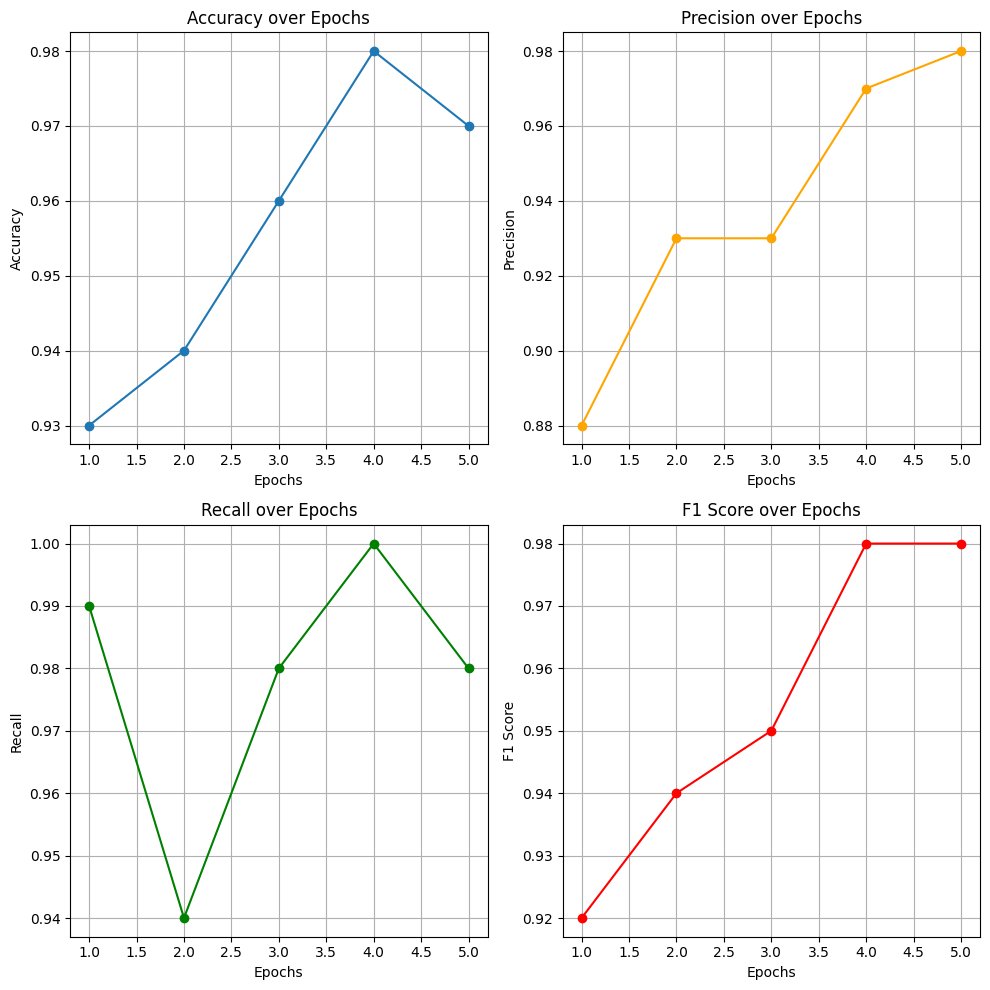

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
accuracy = [0.93, 0.94, 0.96, 0.98, 0.97]
precision = [0.88, 0.93, 0.93, 0.97, 0.98]
f1_scores = [0.92, 0.94, 0.95, 0.98, 0.98]
recall = [0.99, 0.94, 0.98, 1.00, 0.98]

epochs = np.arange(1, len(accuracy) + 1)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Accuracy
axs[0, 0].plot(epochs, accuracy, marker='o')
axs[0, 0].set_title('Accuracy over Epochs')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].grid()

# Precision
axs[0, 1].plot(epochs, precision, marker='o', color='orange')
axs[0, 1].set_title('Precision over Epochs')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Precision')
axs[0, 1].grid()

# Recall
axs[1, 0].plot(epochs, recall, marker='o', color='green')
axs[1, 0].set_title('Recall over Epochs')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].grid()

# F1 Score
axs[1, 1].plot(epochs, f1_scores, marker='o', color='red')
axs[1, 1].set_title('F1 Score over Epochs')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('F1 Score')
axs[1, 1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

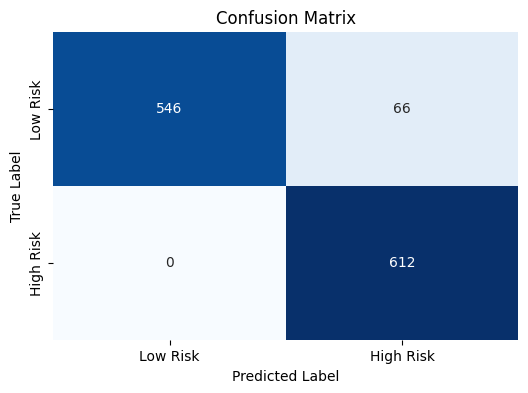

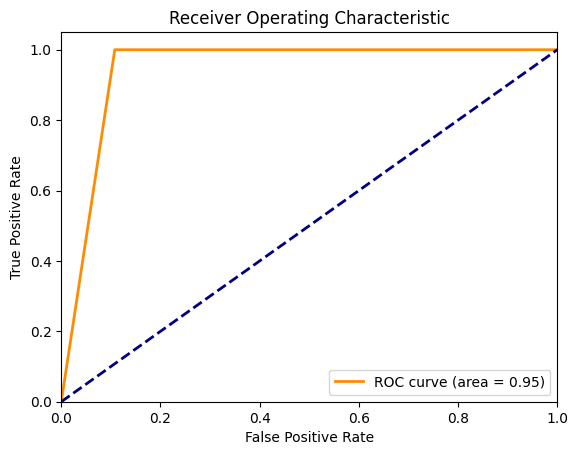

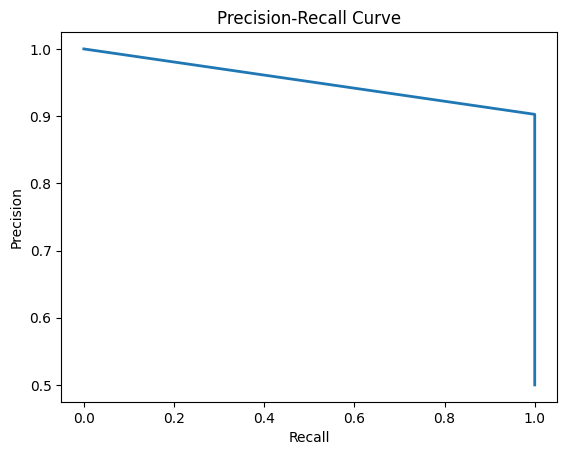

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Load model performance data from the JSON files
with open('hybrid_model_predictions_with_explanations.json') as f:
    predictions_data = json.load(f)

with open('formatted_patient_summaries.json') as f:
    summaries_data = json.load(f)

# Extracting true labels and predictions
true_labels = [entry['label'] for entry in summaries_data]
predicted_labels = [1 if entry['prediction'] == 'High Risk' else 0 for entry in predictions_data]

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
y_scores = [1 if entry['prediction'] == 'High Risk' else 0 for entry in predictions_data]
fpr, tpr, _ = roc_curve(true_labels, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_labels, y_scores)
plt.figure()
plt.plot(recall, precision, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [ ]:
import faiss
import numpy as np

def create_and_save_faiss_index(embeddings_file, index_file):
    """
    Loads embeddings from a .npy file, creates a FAISS index, and saves it to disk.

    Args:
    embeddings_file (str): Path to the .npy file containing the embeddings.
    index_file (str): Path where the FAISS index should be saved.
    """

    # Load embeddings from the specified .npy file
    embeddings = np.load(embeddings_file)

    # Check if embeddings are not empty and have the correct shape
    if embeddings.size == 0 or len(embeddings.shape) != 2:
        raise ValueError("Loaded embeddings are empty or do not have the correct shape.")

    # Create a FAISS index for L2 distance
    index = faiss.IndexFlatL2(embeddings.shape[1])  # L2 norm is common for cosine/euclidean distances

    # Add embeddings to the index
    index.add(embeddings)

    # Save the index to disk
    faiss.write_index(index, index_file)
    print(f"FAISS index created and saved to {index_file}")

if __name__ == "__main__":
    # Specify the path to your embeddings file and the output path for the FAISS index
    embeddings_path = "patient_embeddings.npy"  # This should match the path where your embeddings are stored
    index_output_path = "faiss_index.bin"       # Path to save the FAISS index

    # Call the function to create and save the FAISS index
    create_and_save_faiss_index(embeddings_path, index_output_path)

FAISS index created and saved to faiss_index.bin


In [ ]:
import os

files_to_check = ['patient_embeddings.npy', 'faiss_index.bin']
for file_name in files_to_check:
    if os.path.exists(file_name):
        print(f"{file_name} exists.")
    else:
        print(f"{file_name} does not exist. Please check the path.")

patient_embeddings.npy exists.
faiss_index.bin exists.


In [ ]:
import numpy as np

try:
    embeddings = np.load('patient_embeddings.npy')
    print("Embeddings loaded successfully.")
    print(f"Shape of embeddings: {embeddings.shape}")
    print(f"Data type of embeddings: {embeddings.dtype}")
except Exception as e:
    print(f"Failed to load embeddings: {e}")

Embeddings loaded successfully.
Shape of embeddings: (1224, 384)
Data type of embeddings: float32


In [ ]:
import faiss

try:
    index = faiss.read_index('faiss_index.bin')
    print("FAISS index loaded successfully.")
    # Perform a dummy query to test if the index is working
    if embeddings.size > 0:
        _, _ = index.search(embeddings[0:1], 1)  # Query the first embedding
        print("FAISS index query successful.")
    else:
        print("Embeddings array is empty, can't test query.")
except Exception as e:
    print(f"Failed to load FAISS index: {e}")

FAISS index loaded successfully.
FAISS index query successful.


In [ ]:
if embeddings.dtype != np.float32:
    print("Incorrect data type for FAISS. Converting...")
    embeddings = embeddings.astype(np.float32)
    np.save('patient_embeddings.npy', embeddings)  # Save the corrected embeddings if necessary
    print("Embeddings converted to float32 and saved.")